In [23]:
import opensimplex
import numpy as np
import matplotlib.pyplot as plt
import math
from random import randint
from matplotlib.colors import ListedColormap
import os
import multiprocessing as mp

In [65]:
biomas = np.empty(shape=(128,128,128), dtype=np.uint8)
for i in range(128):
    for j in range(128):
        for k in range(128):
            mejor = float('inf')
            for r in generator.BIOMAS.keys():
                a = np.linalg.norm(np.array(generator.BIOMAS[r][0]) - np.array([i/128, j/128, k/128]))
                if a < mejor:
                    mejor = a
                    biomas[i, j, k] = r
    print(i)
print(biomas)
np.save(f"CERCANIA_BIOMAS.npy", biomas)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
[[[ 2  2  2 ...  0  0  0]
  [ 2  2  2 ...  0  0  0]
  [ 2  2  2 ...  0  0  0]
  ...
  [ 1  1  1 ... 10 10 10]
  [ 1  1  1 ... 10 10 10]
  [ 1  1  1 ... 10 10 10]]

 [[ 2  2  2 ...  0  0  0]
  [ 2  2  2 ...  0  0  0]
  [ 2  2  2 ...  0  0  0]
  ...
  [ 1  1  1 ... 10 10 10]
  [ 1  1  1 ... 10 10 10]
  [ 1  1  1 ... 10 10 10]]

 [[ 2  2  2 ...  0  0  0]
  [ 2  2  2 ...  0  0  0]
  [ 2  2  2 ...  0  0  0]
  ...
  [ 1  1  1 ... 10 10 10]
  [ 1  1  1 ... 10 10 10]
  [ 1  1  1 ... 10 10 10]]

 ...

 [[14 14 14 ...  8  8  8]
  [14 14 14 ...  8  8  8]
  [14 14 14 ...  8  8  8]
  ...
  [13 13 13 ... 

In [66]:
class generator:
    #Humedad altura temperatura
    BIOMAS = {
        0: ([0.1, 0.2, 0.8], "Desierto", "#ffd31d"),
        1: ([0.35, 0.85, 0.35], "Montaña", "#7d7d7d"),
        2: ([0.4, 0.2, 0.35], "Valle", "#90db94"),
        3: ([0.5, 0.2, 0.55], "Bosque", "#35762b"),
        4: ([0.6, 0.2, 0.6], "Selva", "#00b70a"),
        5: ([0.2, 0.2, 0.6], "Savana", "#e47d1c"),
        6: ([0.2, 0.65, 0.55], "Meseta", "#6e5842"),
        7: ([0.5, -0.1, 0.5], "Costa", "#f5f06c"),
        8: ([0.75, 0.25, 0.75], "Termales", "#279c79"),
        9: ([0.35, 0.2, 0.55], "Dehesa", "#80b31e"),
        10: ([0.15, 0.8, 0.85], "Volcanico", "#9f1010"),
        11: ([0.85, 0.05, 0.45], "Marismas", "#abde20"),
        12: ([0.8, 0.15, 0.45], "Pantano", "#218563"),
        13: ([0.65, 0.75, 0.3], "Tundra", "#d0d0f0"), 
        14: ([0.75, 0.1, 0.05], "Polo", "#fafafa"),
        15: ([-1, -1, -1], "Oceano", "#3894c2"),
        16: ([-1, -1, -1], "Oceano profundo", "#1b3b8c"),
        17: ([-1, -1, -1], "Rios y lagos", "#7eb4ed")
    }
    CHUNK_SIZE = 128
    CERCANIA_BIOMAS = np.load("./CERCANIA_BIOMAS.npy", allow_pickle=True)

    def __init__(self, seedTemp = None, seedAltu = None, seedHume = None):
        self.SEEDTEMP = seedTemp if seedTemp != None else randint(-2**30, 2**30)
        self.SEEDALTU = seedAltu if seedTemp != None else randint(-2**30, 2**30)
        self.SEEDHUME = seedHume if seedTemp != None else randint(-2**30, 2**30)

    def getNoise(self, seed: int, x_in: int, y_in: int, iterations: int, size: int):
        """
        Generates Perlin noise using OpenSimplex.

        Args:
            seed (int): Random seed for OpenSimplex.
            x_in (float): X coordinate of the noise point.
            y_in (float): Y coordinate of the noise point.
            iterations (int): Number of noise octaves.

        Returns:
            np.ndarray: 2D array of Perlin noise values.
        """

        x = self.CHUNK_SIZE*x_in
        y = self.CHUNK_SIZE*y_in
        opensimplex.seed(seed)

        rango = range(0,self.CHUNK_SIZE)
        noise_array = np.zeros(dtype=float, shape=(self.CHUNK_SIZE, self.CHUNK_SIZE))

        for r in range(iterations):
            divisor = (size/2**r)
            exponenciador = (2**r)
            for i in rango:
                for j in rango:
                    noise_array[j, i] += opensimplex.noise2(x=(i+x)/divisor, y=(y+j)/divisor)/exponenciador
        
        maximo = sum([2/(2**r) for r in range(iterations)])
        for i in rango:
            for j in rango:
                valor = (noise_array[j, i] + maximo)/(2*maximo)     
                for r in range(3):
                    noise_array[j, i] = 0.5 + math.sin(math.pi*valor - math.pi/2)/2
        return noise_array
    
    def getBioma(self, temp, altu, hume):
        if(altu < 0.5):
            if (altu <= 0.45):
                return 15 #Oceano
            else:
                return 16 #Oceano profundo
        else:
            alt = math.floor(128*(altu-0.5)*2)
            temp = math.floor(128*temp)
            hum = math.floor(128*hume)
            return self.CERCANIA_BIOMAS[hum, alt, temp]

    def getChunk(self, x, y):
        """
        Generates a 2D array of Perlin noise values for a chunk.

        Args:
            x (int): X coordinate of the chunk.
            y (int): Y coordinate of the chunk.

        Returns:
            np.ndarray: 2D array of Perlin noise values.
        """

        if os.path.exists(f"./Chunks/T_{hex(self.SEEDTEMP).replace('0x','')}A_{hex(self.SEEDTEMP).replace('0x','')}H_{hex(self.SEEDTEMP).replace('0x','')}/{x}/{y}.npy"):
            return np.load(f"./Chunks/T_{hex(self.SEEDTEMP).replace('0x','')}A_{hex(self.SEEDTEMP).replace('0x','')}H_{hex(self.SEEDTEMP).replace('0x','')}/{x}/{y}.npy")
        else:
            temp = self.getNoise(self.SEEDTEMP, x, y, 3, 128)
            altu = self.getNoise(self.SEEDALTU, x, y, 6, 256)
            hume = self.getNoise(self.SEEDHUME, x, y, 3, 256)
            array_biomas = np.zeros(dtype=np.uint8, shape=(self.CHUNK_SIZE,self.CHUNK_SIZE))
            for i in range(self.CHUNK_SIZE):
                for j in range(self.CHUNK_SIZE):
                    array_biomas[i, j] = self.getBioma(hume[i, j], altu[i, j], temp[i, j])
            os.makedirs(f"./Chunks/T_{hex(self.SEEDTEMP).replace('0x','')}A_{hex(self.SEEDTEMP).replace('0x','')}H_{hex(self.SEEDTEMP).replace('0x','')}/{x}", exist_ok=True)
            np.save(f"./Chunks/T_{hex(self.SEEDTEMP).replace('0x','')}A_{hex(self.SEEDTEMP).replace('0x','')}H_{hex(self.SEEDTEMP).replace('0x','')}/{x}/{y}", array_biomas)
            return array_biomas
    
    def getChunksInRange(self, x_range: tuple[int, int], y_range: tuple[int, int]):
        arr = None
        for i in range(x_range[0], x_range[1]):
            arr_proc = []
            for j in range(y_range[0], y_range[1]):
                arr_proc.append(mp.Process(target=self.getChunk, args=(i, j)))
            for r in range(len(arr_proc)):
                arr_proc[r].start()
            for r in range(len(arr_proc)):
                arr_proc[r].join()

            arr_line = None
            for j in range(y_range[0], y_range[1]):
                if arr_line is None:
                    arr_line = self.getChunk(i, j)
                else:
                    arr_line = np.vstack((arr_line, self.getChunk(i, j)))

            if arr is None:
                arr = arr_line
            else:
                arr = np.hstack((arr, arr_line))
        return arr

    def representation(self, x_range: tuple[int, int], y_range: tuple[int, int]):

        arr = self.getChunksInRange(x_range, y_range)

        fig, ax = plt.subplots(figsize=(25, 25)) 
        # Create the colormap

        cmap = ListedColormap([self.BIOMAS[key][2] for key in self.BIOMAS.keys()])

        # Plot the image using imshow with the specified colormap
        im = ax.imshow(arr, cmap=cmap, interpolation='none')

        # Add a colorbar with custom labels
        cbar = plt.colorbar(im, ticks=list(self.BIOMAS.keys()))  # Set ticks to biome IDs
        cbar.ax.set_yticklabels([f"id {key}:{self.BIOMAS[key][1]}" for key in self.BIOMAS.keys()])  # Set labels to biome names

        # Set the title and labels
        ax.set_title('2D Array with Colormap')
        ax.set_xlabel('X-axis')
        ax.set_ylabel('Y-axis')

        # Show the plot
        plt.show()

In [67]:
a = generator(1343, 4132,131222)

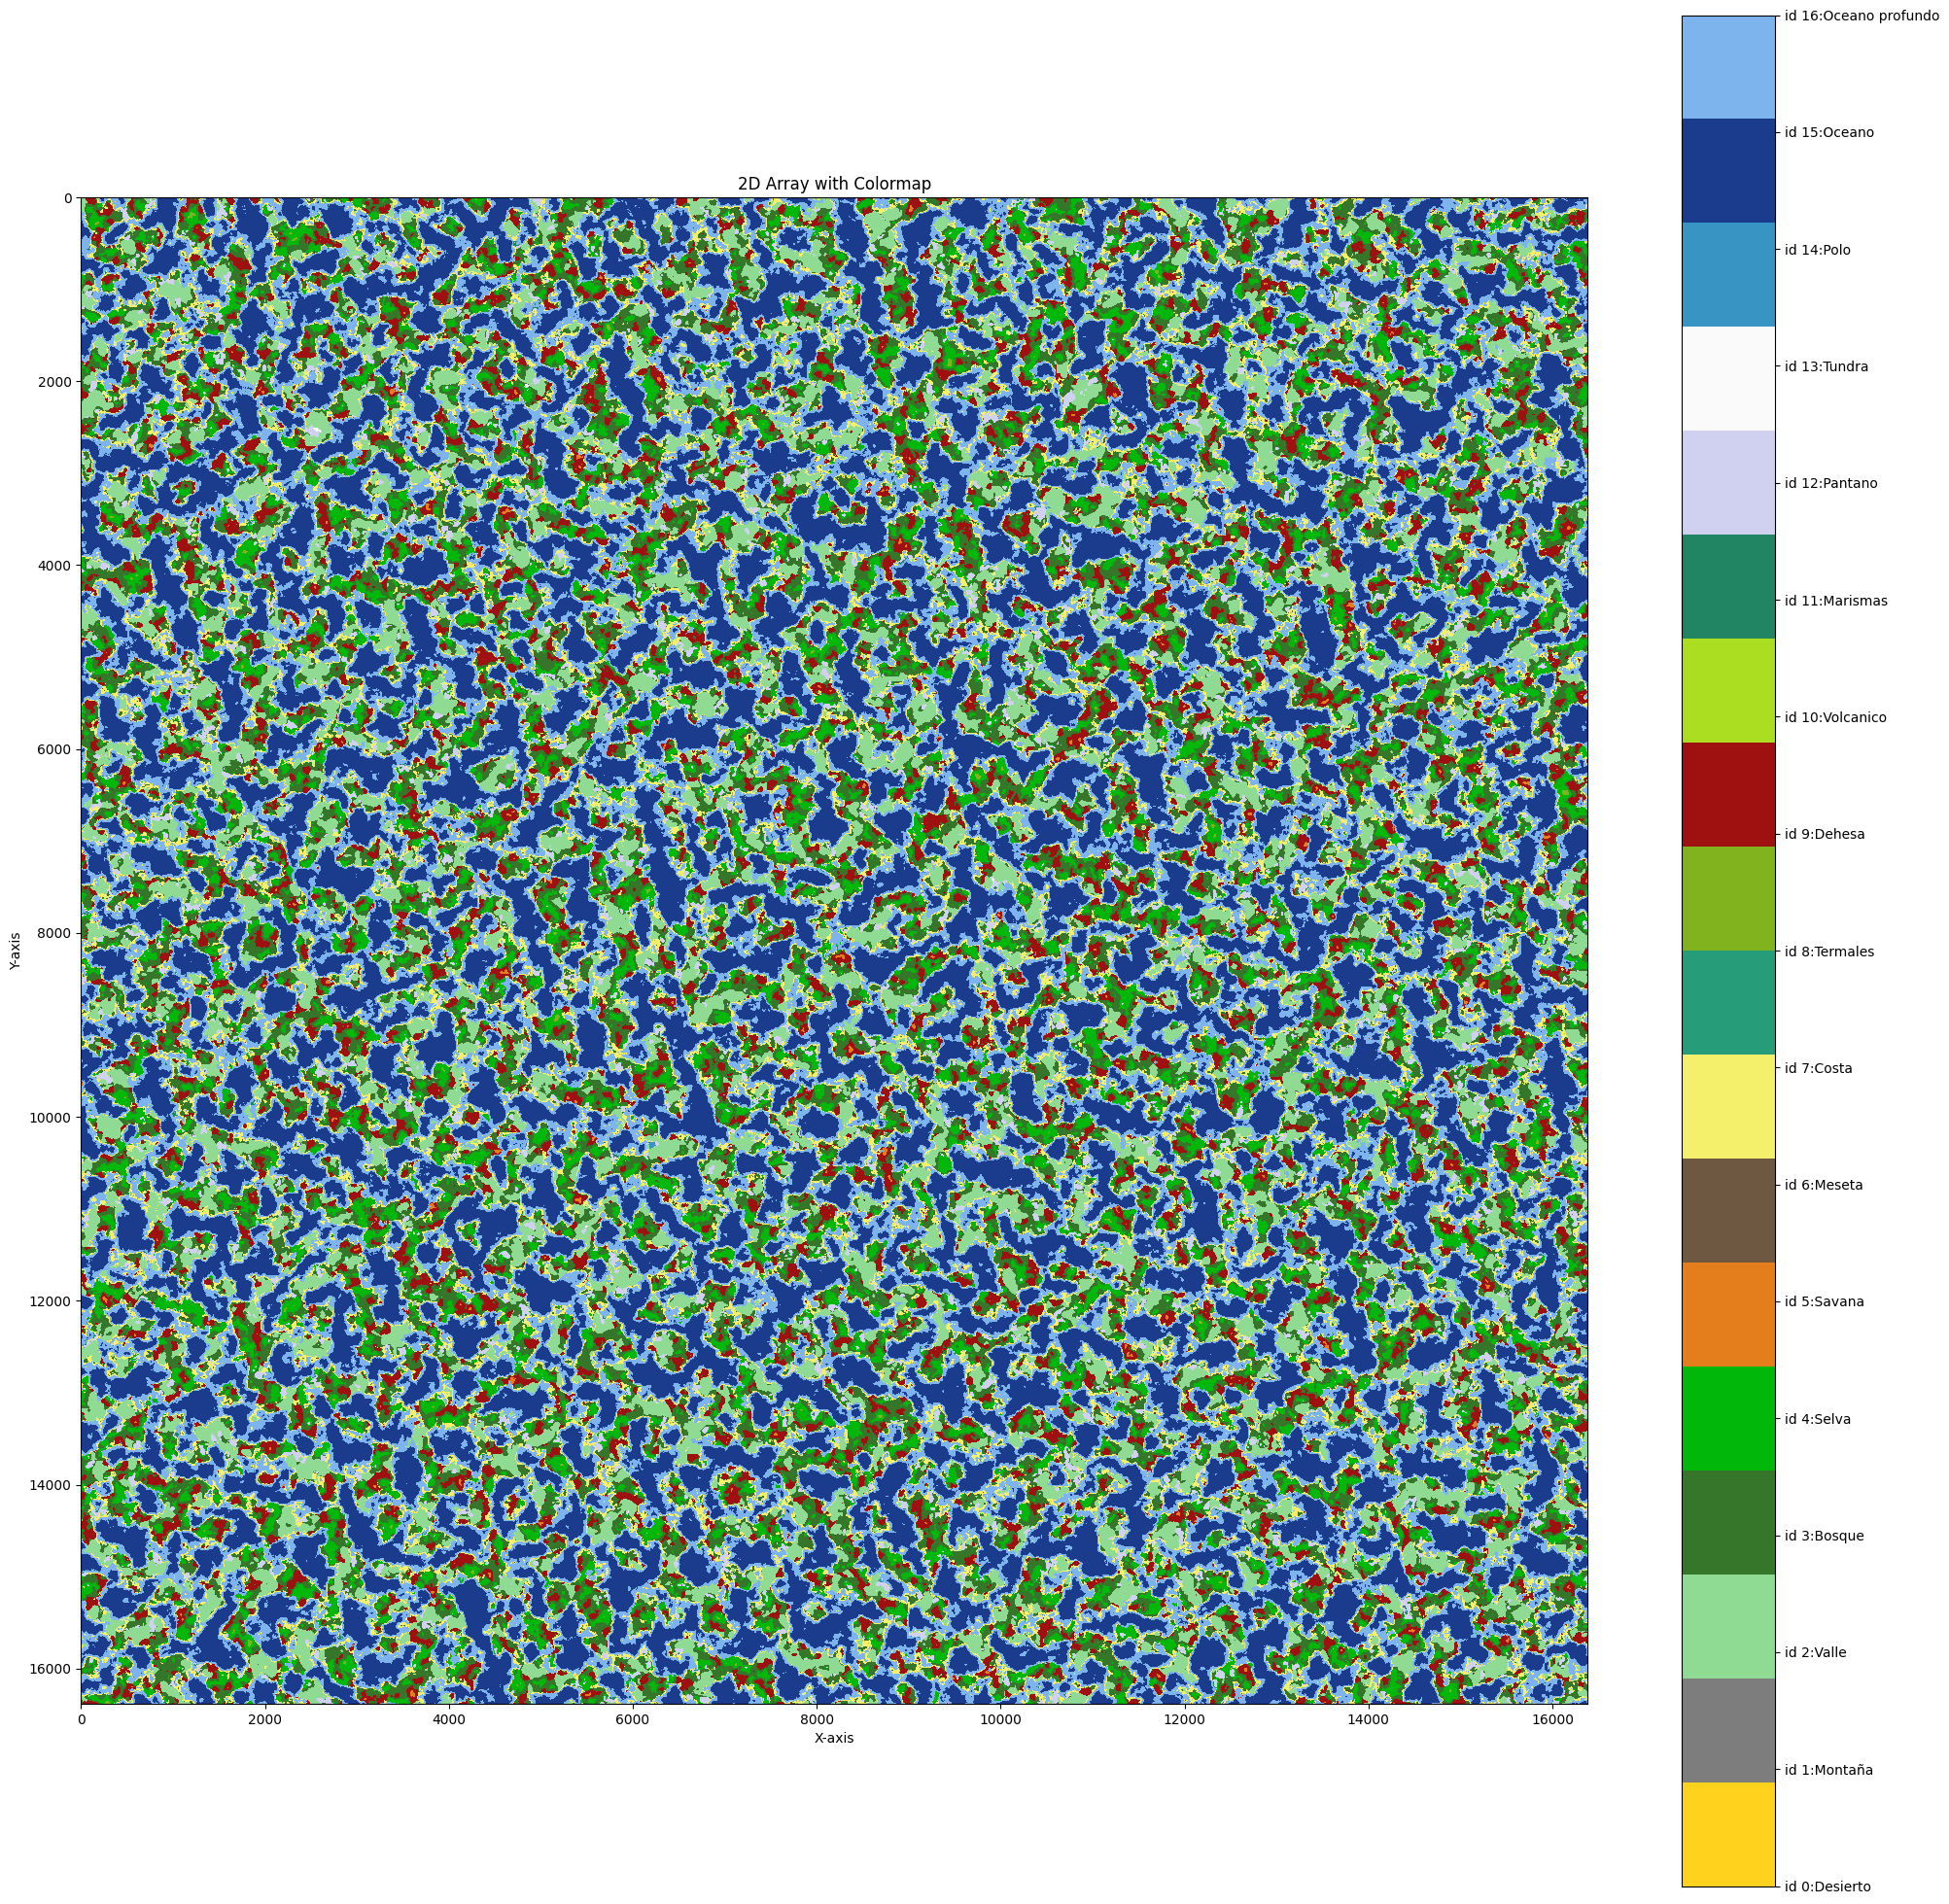

In [70]:
a.representation((0,128),(0,128))
